# Импорт библиотек и загрузка данных

In [6]:
!pip install pymorphy2
!pip install --upgrade scikit-learn
!pip install --upgrade keras
!pip install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=9ae2569a275bdf745d4e720b2673a6bd3e9057ae868d28fe42ccd690f0e45223
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import uniform_filter1d
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import time
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer

import re
import keras
import pymorphy2
import string
from string import punctuation
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
read_data = pd.read_csv("data.csv")

In [10]:
data = read_data.copy()
data.head()

,text,label
0,"В данный момент пишу диплом на тему ""моделиров...",process
1,Стараюсь вникнуть в основу продуктового менедж...,process
2,Я два раза участвовала в кейсах по маркетингу ...,result
3,Мы с командой вели проект по разработке прилож...,process
4,Мы с командой создали проект по разработке при...,result


# Предобработка данных

In [11]:
def get_corpus(text):
    corpus = []
    for sent in text:
        for word in sent.split():
            corpus.append(word)
    return corpus

def draw_word_cloud(corpus):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=3000, height=2000, max_words=200, random_state=42,
                              background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

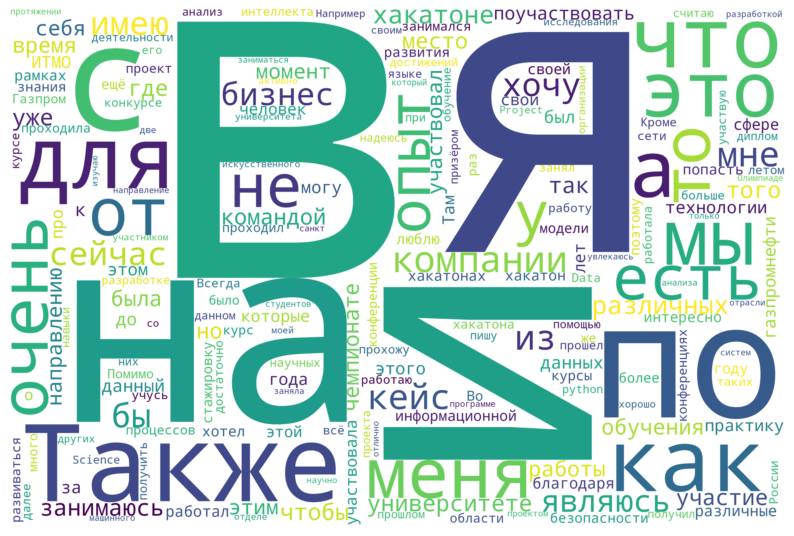

In [12]:
corpus = get_corpus(data['text'].values)
draw_word_cloud(corpus)

In [13]:
num_words = len(set(corpus))
print("Количество уникальных слов в выборке: ", num_words)

Количество уникальных слов в выборке:  2903


In [14]:
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление символов, кроме буквенно-цифровых
    text = re.sub(r"[^\w\s]", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    # Лемматизация и стемминг
    lemmatized_tokens = []
    for token in tokens:
        parsed_token = morph.parse(token)[0]
        if 'VERB' in parsed_token.tag:
            lemmatized_tokens.append(parsed_token.tag.aspect) # вид глагола
            # lemmatized_tokens.append(parsed_token.tag.aspect + '_' + parsed_token.tag.tense)
        if parsed_token.normal_form.isdigit():
            lemmatized_tokens.append('num') # числа

        # Удаление стоп-слов
        if not parsed_token.normal_form.isdigit() and parsed_token.normal_form not in stop_words:
            lemma = SnowballStemmer('russian').stem(parsed_token.normal_form)
            lemmatized_tokens.append(lemma)            

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

print(preprocess_text("«Я в июне взял и поставил опять рекорд по выпитым литрам воды - целых сто 100!!!"))

июн perf взят perf постав рекорд вып литр вод цел сто num


In [15]:
data['clean'] = data['text'].map(lambda x : preprocess_text(x))
data['label_num'] = data['label'].apply(lambda x: 1 if x == 'result' else 0)
data = data[['clean', 'label_num', 'label']]
tokenizer = RegexpTokenizer(r'\w+')
data['tokens'] = data['clean'].apply(tokenizer.tokenize)
data.head(5)
data = data.dropna() 
data = data.reset_index(drop=True)
data.head(5)

,clean,label_num,label,tokens
0,дан момент impf писа дипл тем моделирован проц...,0,process,"[дан, момент, impf, писа, дипл, тем, моделиров..."
1,impf стара вникнут основ продуктов менеджмент ...,0,process,"[impf, стара, вникнут, основ, продуктов, менед..."
2,impf участвова кейс маркетинг реклам пиар об p...,1,result,"[impf, участвова, кейс, маркетинг, реклам, пиа..."
3,команд вел проект разработк приложен анализ те...,0,process,"[команд, вел, проект, разработк, приложен, ана..."
4,команд perf созда проект разработк приложен ан...,1,result,"[команд, perf, созда, проект, разработк, прило..."


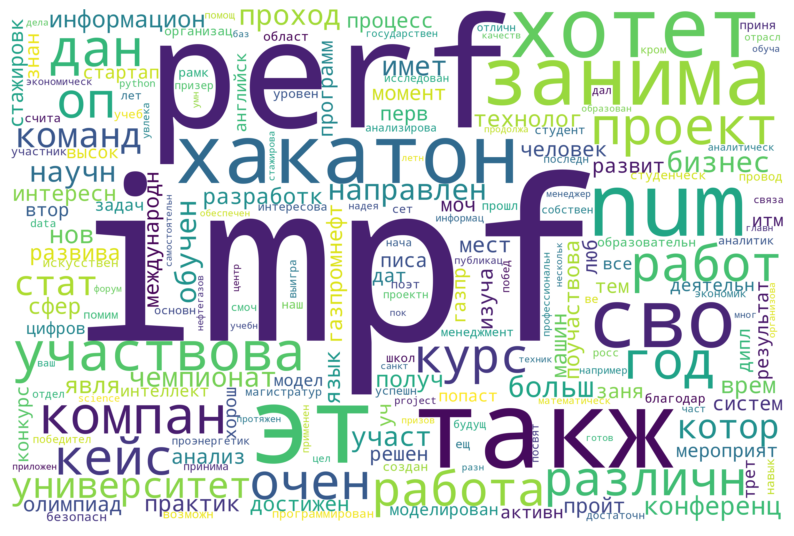

In [16]:
corpus_clean = get_corpus(data['clean'].values)
draw_word_cloud(corpus_clean)

In [17]:
num_words = len(set(corpus_clean))
print("Количество уникальных слов в выборке: ", num_words)

Количество уникальных слов в выборке:  1520


In [18]:
data.groupby('label').count()

,clean,label_num,tokens
label,,,
process,292,292,292
result,240,240,240


Выборка сбалансированна. В том числе благодаря ручной аугментации при ее составлении.

# Выбор способа векторизации текста

## Bag of words + Логистическая регрессия

In [19]:
corpus = data['clean'].tolist()
labels = data['label_num'].tolist()
X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.1, random_state=40)

count_vectorizer = CountVectorizer()
X_train_bof = count_vectorizer.fit_transform(X_train)
X_test_bof = count_vectorizer.transform(X_test)

In [20]:
def plot_LSA(test_data, test_labels, method):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['firebrick', 'slateblue']
    plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=20, alpha=0.6, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    plt.legend(handles=[mpatches.Patch(color='firebrick', label='Result'), mpatches.Patch(color='slateblue', label='Process')])
    plt.xlabel('LSA Component 1')
    plt.ylabel('LSA Component 2')
    plt.title('LSA Plot for ' + method)


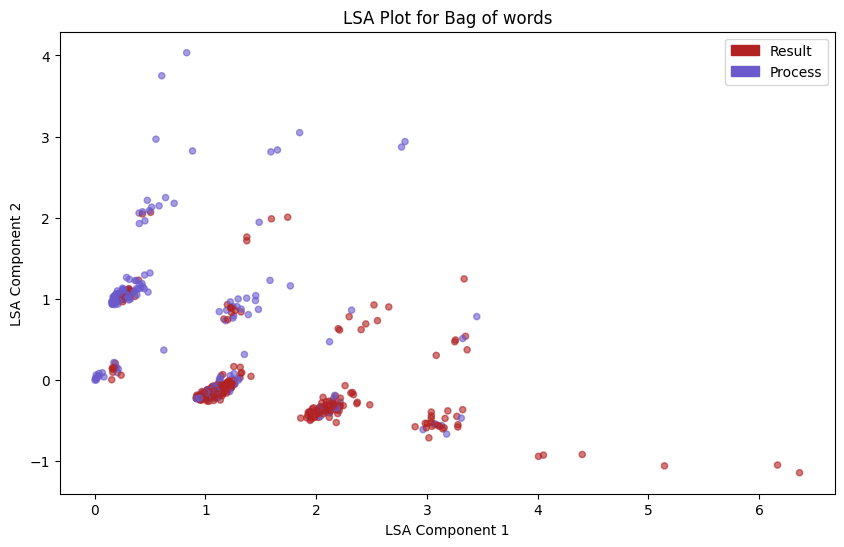

In [21]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_bof, y_train, "Bag of words")
plt.show()


Здесь можно видеть график LSA, демонстрирующий как данные разделены на классы в пространстве двух компонент LSA. Визуализация позволяет увидеть, насколько успешно классы разделяются на основе доступных признаков. Здесь видно, что разделение не самое очевидное.

In [36]:
start_time = time.time()

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['ovr', 'multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_bof, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()
logreg_clf_bof = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")

y_predicted_bof = logreg_clf_bof.predict(X_test_bof)
# 0.7811764705882351
# 0.7740350877192983 
# 0.7782675438596491

Best params = {'C': 464.15888336127773, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.7782675438596491

Общее время обучения модели: 4.637117385864258 секунд


In [23]:
def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, average='weighted') # TP / (TP + FP)            
    recall = recall_score(y_test, y_predicted, average='weighted') # TP / (TP + FN)
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [24]:
print("Train accuracy = ", accuracy_score(y_train, logreg_clf_bof.predict(X_train_bof)))
print("Test accuracy = ", accuracy_score(y_test, logreg_clf_bof.predict(X_test_bof)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_bof)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))
# 0.822429906542056   0.2 train-test split
# 0.87037   0.1 train-test split
# 0.83333    num

Train accuracy =  1.0
Test accuracy =  0.8333333333333334

accuracy = 0.83333, precision = 0.84722, recall = 0.83333, f1 = 0.83305


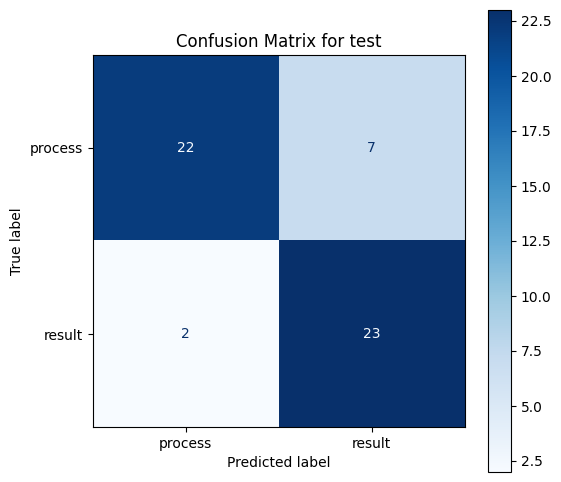

In [25]:
cm = confusion_matrix(y_test, logreg_clf_bof.predict(X_test_bof))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix for test")
plt.show()

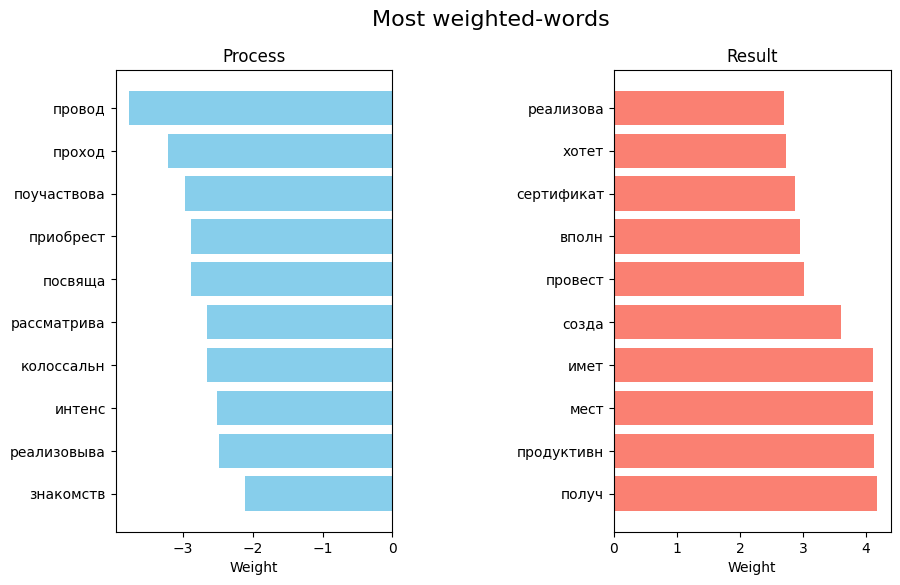

In [26]:
def important_features(vectorizer, model, n=10):
    result = {}
    index_to_word = {x: a for a, x in vectorizer.vocabulary_.items()}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        result[class_index] = {'top': sorted_coeff[:n], 'bottom': sorted_coeff[-n:]}
    return result

important = important_features(count_vectorizer, logreg_clf_bof)[0]
top_scores = [_[0] for _ in important['top']]
bottom_scores = [_[0] for _ in important['bottom']]
top_words = [_[1] for _ in important['top']]
bottom_words = [_[1] for _ in important['bottom']]

def show_words_top_important(top_scores, top_words, bottom_scores, bottom_words):
    tmp = range(len(top_words))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    ax1.barh(tmp, bottom_scores, color='skyblue')
    ax1.set_title('Process', fontsize=12)
    ax1.set_yticks(tmp)
    ax1.set_yticklabels(bottom_words, fontsize=10)
    ax1.set_xlabel('Weight', fontsize=10)
    
    ax2.barh(tmp, top_scores, color='salmon')
    ax2.set_title('Result', fontsize=12)
    ax2.set_yticks(tmp)
    ax2.set_yticklabels(top_words, fontsize=10)
    ax2.set_xlabel('Weight', fontsize=10)
    
    fig.suptitle("Most weighted-words", fontsize=16)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

show_words_top_important(top_scores, top_words, bottom_scores, bottom_words)


In [80]:
import plotly.graph_objects as go
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(logreg_clf_bof, X_train_bof, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=1.0, y=0.05),
    width=1000,
    height=500,
)
fig.show()


Падения validation score в значении 200 заставляет невольно задуматься, как будет вести себя эта модель при дальнейшем обучении? Хотелось бы избежать непредсказуемость

## TF-IDF + Bag of words + Логистическая регрессия

In [28]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = count_vectorizer.transform(X_test)

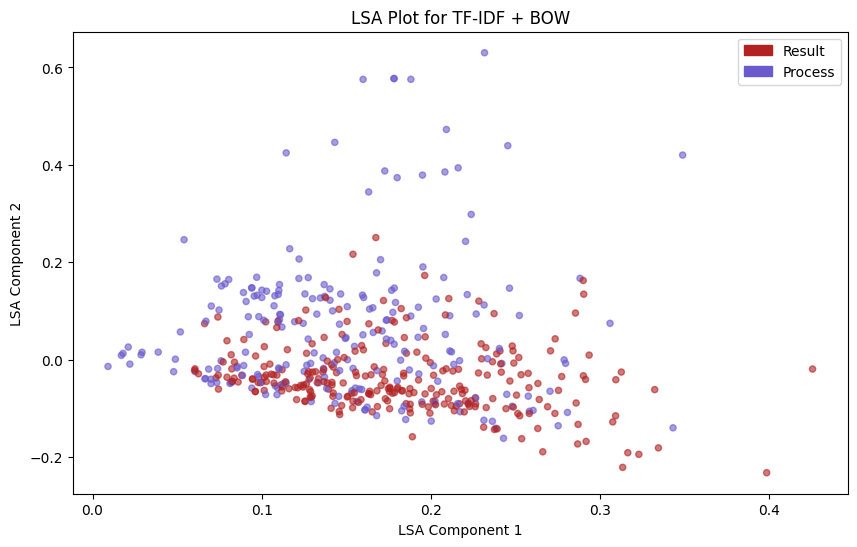

In [29]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_tf, y_train, "TF-IDF + BOW")
plt.show()

Здесь можно наблюдать более точное разделение между цветами. Тем не менее, результат не идеален, в том числе и из-за того, что выборка небольшого размера

In [30]:
start_time = time.time()

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['ovr', 'multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_tf, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()
logreg_clf_tf = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")

y_predicted_tf = logreg_clf_tf.predict(X_test_tf)
# 0.7788235294117648  0.2 train-test split
# 0.778267543859649   0.1 train-test split
# 0.7845394736842104  num

Best params = {'C': 4.641588833612778, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.7845394736842104

Общее время обучения модели: 3.741848945617676 секунд


In [31]:
print("Train accuracy = ", accuracy_score(y_train, logreg_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, logreg_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))
# 0.7663551401869159  0.2 train-test split
# 0.81481  0.1 train-test split
# 0.81481  num

Train accuracy =  0.99581589958159
Test accuracy =  0.8148148148148148

accuracy = 0.81481, precision = 0.81995, recall = 0.81481, f1 = 0.81274


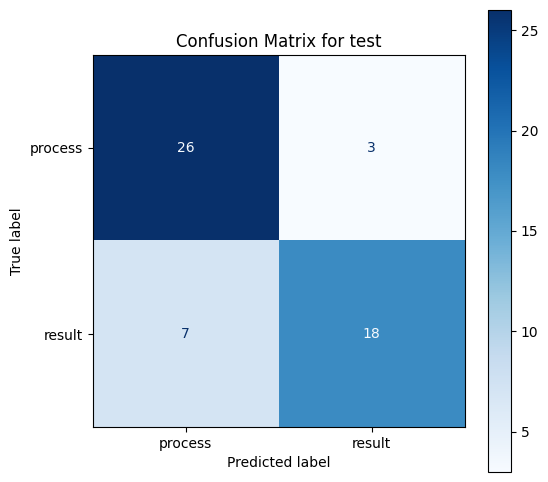

In [32]:
cm = confusion_matrix(y_test, logreg_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix for test")
plt.show()

Ожидания не опрадались. По какой-то причине наложение tf-idf ухудшило результат. Проверим, насколько релевантно это изменение:

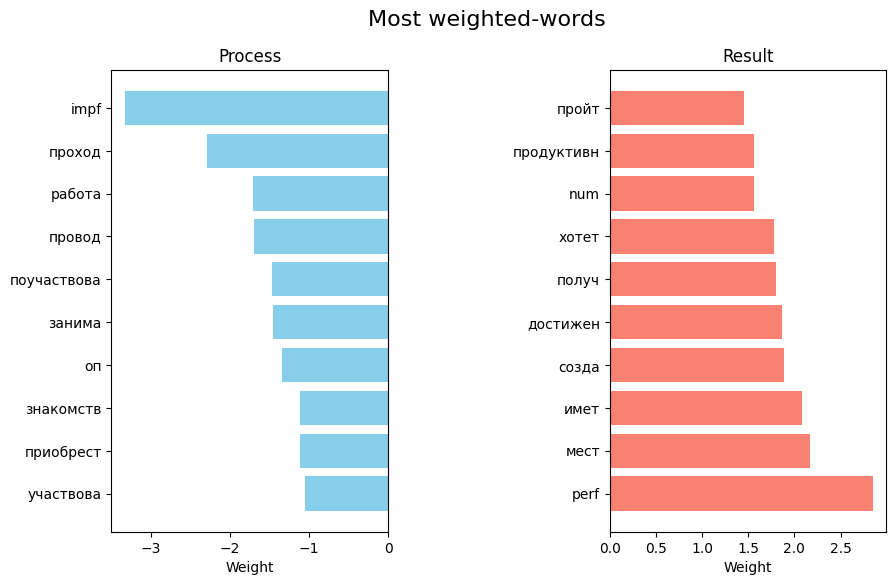

In [33]:
important = important_features(count_vectorizer, logreg_clf_tf)[0]
top_scores = [_[0] for _ in important['top']]
bottom_scores = [_[0] for _ in important['bottom']]
top_words = [_[1] for _ in important['top']]
bottom_words = [_[1] for _ in important['bottom']]
show_words_top_important(top_scores, top_words, bottom_scores, bottom_words)


Судя по весам слов на графике выше, все логично и улучшилось по сравнению с обычной векторизацией без наложения поверх TF-IDF. Информация о форме глагола играет очень важную роль в этой задаче, для этого мы и ввели этот признак вручную. Поэтому сейчас мы жертвуем точностью модели (0.81481 против 0.83333) в пользу качества модели и улучшения ее ожидаемого поведения на новых данных. Возможно, имело место переобучение или острая реакция на выбросы, потому как в выборке могут часто появляться некоторые слова в силу специфики выборки, но в предыдущем варианте это проявилось сильнее.

In [79]:
train_sizes, train_scores, val_scores = learning_curve(logreg_clf_tf, X_train_tf, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=0.82, y=0.05),
    width=1000,
    height=500,
)
fig.show()


Стабильный рост validation score!

## Word2Vec + Логистическая регрессия

In [39]:
start_time = time.time()

processed_texts = [text.split() for text in X_train]
model = Word2Vec(processed_texts, min_count=1)

X_train_w2v = []
for doc in processed_texts:
    doc_vector = np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)
    X_train_w2v.append(doc_vector)

X_train_w2v = np.array(X_train_w2v)

param_grid = {
        'C': np.logspace(0, 3, 10),
        'max_iter': [100],
        'class_weight': ['balanced'],
        'multi_class': ['ovr', 'multinomial'],
        'n_jobs' : [-1]
    }

grid_search = GridSearchCV(LogisticRegression(), param_grid,
                            scoring='accuracy', cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_w2v, y_train)

best_params = grid_search.best_params_
print("Best params =", best_params)
print("Best score =", grid_search.best_score_)
print()
logreg_clf_w2v = grid_search.best_estimator_

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")

y_pred = logreg_clf_w2v.predict(X_train_w2v)


Best params = {'C': 1000.0, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1}
Best score = 0.6966447368421053

Общее время обучения модели: 3.8513524532318115 секунд


In [40]:
print()
print("Train accuracy = ", accuracy_score(y_train, y_pred))

processed_texts_test = [text.split() for text in X_test]
X_test_w2v = []
for doc in processed_texts_test:
    doc_vector = np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)
    X_test_w2v.append(doc_vector)
X_test_w2v = np.array(X_test_w2v)
y_pred = logreg_clf_w2v.predict(X_test_w2v)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Test accuracy = ", accuracy)
print()
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))
print("\nConfusion Matrix:\n", confusion_mat)
# 0.8411214953271028  0.2 train-test split
# 0.81481   0.1 train-test split


Train accuracy =  0.7677824267782427
Test accuracy =  0.7962962962962963

accuracy = 0.79630, precision = 0.75000, recall = 0.84000, f1 = 0.79245

Confusion Matrix:
 [[22  7]
 [ 4 21]]


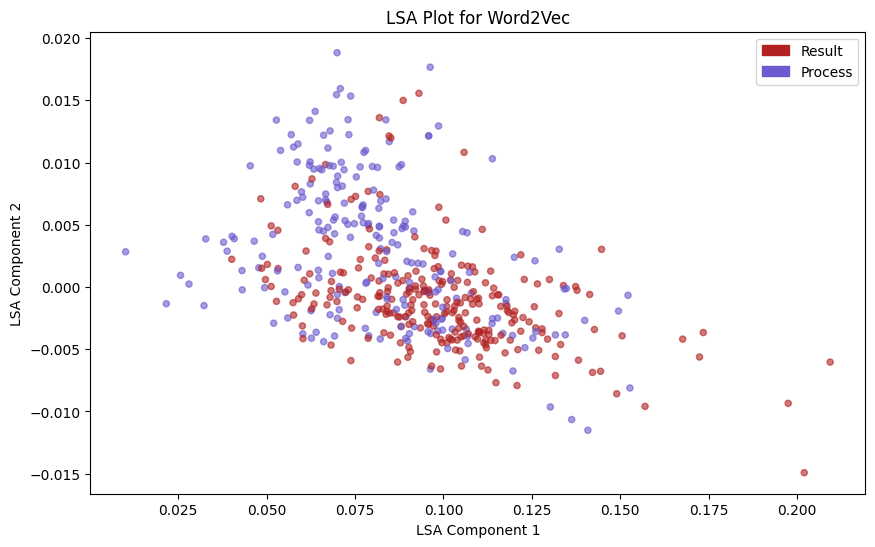

In [854]:
fig = plt.figure(figsize=(10, 6))
plot_LSA(X_train_w2v, y_train, "Word2Vec")
plt.show()

In [944]:
train_sizes, train_scores, val_scores = learning_curve(logreg_clf_w2v, X_train_w2v, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=0.82, y=0.05),
    width=1000,
    height=500,
)
fig.show()


Стало хуже и это объяснимо. Больше на этой выборке использовать Word2Vec нет смысла, потому что она маленькая. Более того, очень странно себя ведет Learning Curve, стоит заметить, что такое поведение непредсказуемо в дальнейшем.

In [856]:
word_vectors = model.wv.vectors
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(word_vectors)
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)
fig = px.scatter(x=word_vectors_pca[:, 0], y=word_vectors_pca[:, 1], color=clusters, hover_name=model.wv.index_to_key)
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Слова перемешаны и мало поддается объяснению именно такое смешение. Такое векторное представление слов действительно не подходит. Также высок риск переобучения, скорее всего оно и произошло – модель подогнала себя под выбросы и запомнила их.

## Сравнение способов векторизации

In [894]:
y_pred_bof = logreg_clf_bof.predict_proba(X_test_bof)[:, 1]
y_pred_tf = logreg_clf_tf.predict_proba(X_test_tf)[:, 1]
y_pred_w2v = logreg_clf_w2v.predict_proba(X_test_w2v)[:, 1]

# Вычисление AUC-ROC для каждой модели
auc_bof = roc_auc_score(y_test, y_pred_bof)
auc_tf = roc_auc_score(y_test, y_pred_tf)
auc_w2v = roc_auc_score(y_test, y_pred_w2v)

fpr_bof, tpr_bof, _ = roc_curve(y_test, y_pred_bof)
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_tf)
fpr_w2v, tpr_w2v, _ = roc_curve(y_test, y_pred_w2v)

# Сглаживание кривых с помощью скользящего среднего
smooth_window_size = 5
fpr_bof_smooth = uniform_filter1d(fpr_bof, size=smooth_window_size)
tpr_bof_smooth = uniform_filter1d(tpr_bof, size=smooth_window_size)
fpr_tf_smooth = uniform_filter1d(fpr_tf, size=smooth_window_size)
tpr_tf_smooth = uniform_filter1d(tpr_tf, size=smooth_window_size)
fpr_w2v_smooth = uniform_filter1d(fpr_w2v, size=smooth_window_size)
tpr_w2v_smooth = uniform_filter1d(tpr_w2v, size=smooth_window_size)


In [916]:
print("AUC ROC показатели:\n")
print("Bag of words   %.5f" % (auc_bof))
print("TF-IDF         %.5f" % (auc_tf))
print("Word2Vec       %.5f" % (auc_w2v))

AUC ROC показатели:

Bag of words   0.91586
TF-IDF         0.91034
Word2Vec       0.85931


In [923]:
# Построение AUC-ROC кривых
trace_bof = go.Scatter(x=fpr_bof_smooth, y=tpr_bof_smooth, mode='lines', name='LogReg-BoW (AUC = {:.2f})'.format(auc_bof), line=dict(color='royalblue'))
trace_tf = go.Scatter(x=fpr_tf_smooth, y=tpr_tf_smooth, mode='lines', name='LogReg-TF-IDF (AUC = {:.2f})'.format(auc_tf), line=dict(color='crimson'))
trace_w2v = go.Scatter(x=fpr_w2v_smooth, y=tpr_w2v_smooth, mode='lines', name='LogReg-Word2Vec (AUC = {:.2f})'.format(auc_w2v), line=dict(color='limegreen'))
random_classifier = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(dash='dash', color='mediumpurple'))
custom_vert = go.Scatter(x=[0, 0], y=[0, 1], mode='lines', showlegend=False, line=dict(color='thistle'))
custom_hor = go.Scatter(x=[0, 1], y=[1, 1], mode='lines', showlegend=False, line=dict(color='thistle'))
ideal_classifier = go.Scatter(x=[0], y=[1], mode='markers', name='Ideal Classifier', marker=dict(size=15, symbol='circle', color='plum', opacity=0.6), )

fig = go.Figure(data=[custom_vert, custom_hor, trace_bof, trace_tf, trace_w2v, random_classifier, ideal_classifier])
fig.update_layout(
    title='Smoothed AUC-ROC Curve Comparison',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.7, y=0.1),
)
fig.add_annotation(x=0, y=1, text='Идеальный классификатор', showarrow=True, arrowhead=1, ax=-30, ay=-30, font=dict(size=13),
)
fig.show()


## Вывод

Итак, вывод по примененным нами способам представить текст числено: 

Лучшие показатели точности логистическая регрессия дает с Bag of words, однако корректно с точки зрения весов отдельных токенов и отсюда более объяснимо она себя ведет с комбинацией TF-IDF + Bag of words. Выводы о подобной обработке текста делаются на основе логистической регресси потому, что она универсальна и более ясна в трактовании тех или иных ее параметров, чем многие другие алгоритмы.


AUC ROC для BoW незначительно больше (всего 0.005), а поведение менее объяснимо и прозрачно, чем для TF-IDF + BoW.


**В дальнейшем будет использовано сочетание TF-IDF + Bag of words.**

# Выбор модели


## Multinomual Naive Bayes

In [41]:
def mnb_train_model(X_train, y_train):
    alphas = np.linspace(0.1, 1.0, 20)
    fit_prior_options = [True, False]
    class_prior_options = [None, [0.2, 0.8], [0.4, 0.6], [0.6, 0.4], [0.8, 0.2]]
    
    param_grid = {
        'alpha': alphas,
        'fit_prior': fit_prior_options,
        'class_prior': class_prior_options
    }
    grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_
    
    return model


In [42]:
start_time - time.time()

mnb_clf_tf = mnb_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = mnb_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, mnb_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, mnb_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best parameters: {'alpha': 0.9526315789473684, 'class_prior': None, 'fit_prior': False}
Best score = 0.7573245614035087

Общее время обучения модели: 164.57093167304993 секунд

Train accuracy =  0.9602510460251046
Test accuracy =  0.8148148148148148

accuracy = 0.81481, precision = 0.81481, recall = 0.81481, f1 = 0.81481


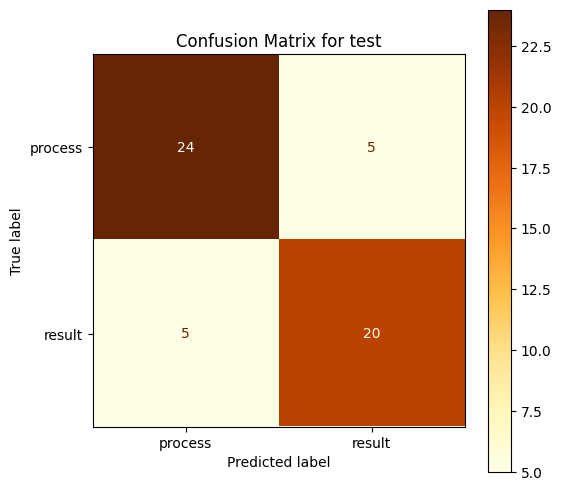

In [43]:
cm = confusion_matrix(y_test, mnb_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for test")
plt.show()

## Метод опорных векторов

In [58]:
def svm_train_model(X_train, y_train):
    param_grid = {
        'C': np.logspace(0, 2, 10),
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [1, 2],
        'class_weight': ['balanced'],
        'probability' : [True]
    }
    grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_

    return model


In [59]:
start_time = time.time()

svm_clf_tf = svm_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = svm_clf_tf.predict(X_test_tf)

print("Train accuracy = ", accuracy_score(y_train, svm_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, svm_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'C': 12.91549665014884, 'class_weight': 'balanced', 'degree': 1, 'kernel': 'rbf', 'probability': True}
Best score = 0.7762061403508772

Общее время обучения модели: 34.93177890777588 секунд

Train accuracy =  1.0
Test accuracy =  0.5740740740740741

accuracy = 0.57407, precision = 0.71145, recall = 0.57407, f1 = 0.51619


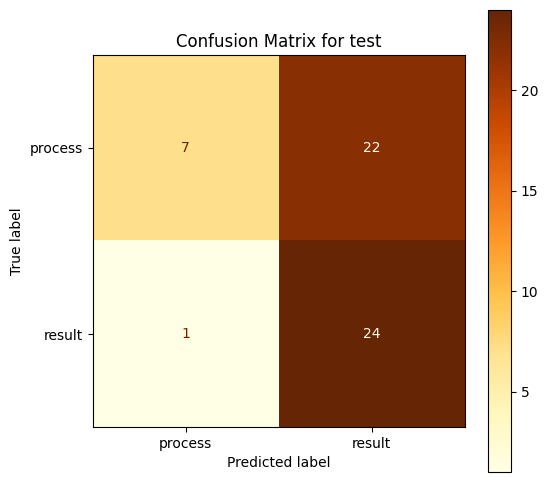

In [60]:
cm = confusion_matrix(y_test, svm_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for test")
plt.show()

## Случайный лес

In [47]:
def rf_train_model(X_train, y_train):
    param_grid = {
        'n_estimators' : [100],
        'max_depth': range(1,11),
        'max_features': [10]
    }
    
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_

    return model


In [48]:
start_time = time.time()

rf_clf_tf = rf_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = rf_clf_tf.predict(X_test_tf)
print("Train accuracy = ", accuracy_score(y_train, rf_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, rf_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'max_depth': 10, 'max_features': 10, 'n_estimators': 100}
Best score = 0.6757894736842105

Общее время обучения модели: 10.170654296875 секунд

Train accuracy =  0.8200836820083682
Test accuracy =  0.7037037037037037

accuracy = 0.70370, precision = 0.77057, recall = 0.70370, f1 = 0.67490


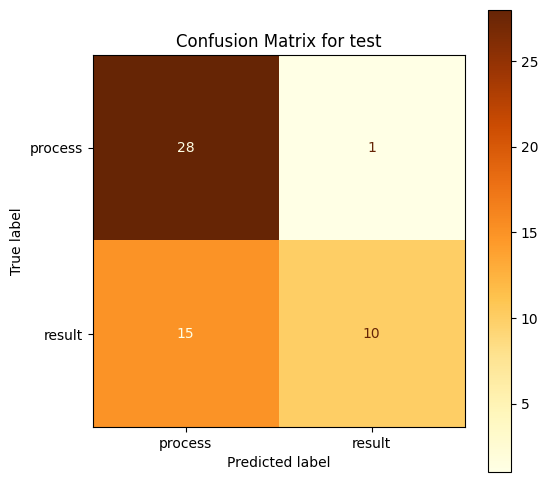

In [49]:
cm = confusion_matrix(y_test, rf_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for test")
plt.show()

## Градиентный бустинг

In [50]:
def gb_train_model(X_train, y_train):
    param_grid = {
        "learning_rate": [0.1, 0.3],
        'max_depth': range(1,7),
        "criterion": ["friedman_mse"],
        "n_estimators":[100]
    }
    
    grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best params =", best_params)
    print("Best score =", grid_search.best_score_)
    print()
    model = grid_search.best_estimator_
 
    return model


In [51]:
start_time = time.time()

gb_clf_tf = gb_train_model(X_train_tf, y_train)

end_time = time.time()
total_time = end_time - start_time
print("Общее время обучения модели:", total_time, "секунд")
print()
y_predicted_tf = gb_clf_tf.predict(X_test_tf)
print("Train accuracy = ", accuracy_score(y_train, gb_clf_tf.predict(X_train_tf)))
print("Test accuracy = ", accuracy_score(y_test, gb_clf_tf.predict(X_test_tf)))
print()
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.5f, precision = %.5f, recall = %.5f, f1 = %.5f" % (accuracy, precision, recall, f1))

Best params = {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score = 0.7532894736842106

Общее время обучения модели: 26.15798854827881 секунд

Train accuracy =  1.0
Test accuracy =  0.7962962962962963

accuracy = 0.79630, precision = 0.80164, recall = 0.79630, f1 = 0.79651


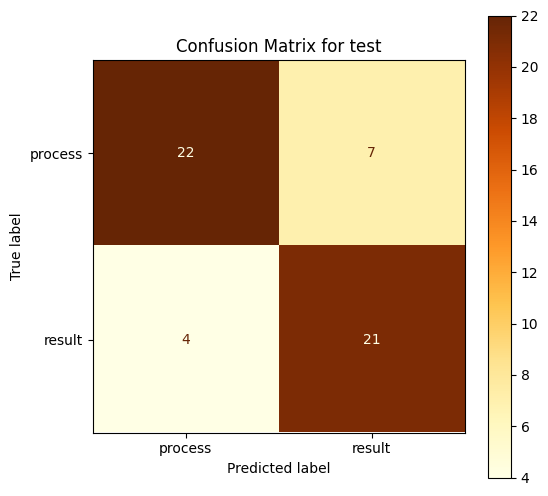

In [52]:
cm = confusion_matrix(y_test, gb_clf_tf.predict(X_test_tf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['process', 'result'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix for test")
plt.show()

## Сравнение моделей

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.ndimage import uniform_filter1d

def compute_auc_roc(y_test, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    fpr_smooth = uniform_filter1d(fpr, size=5)
    tpr_smooth = uniform_filter1d(tpr, size=5)
    return auc, fpr, tpr, fpr_smooth, tpr_smooth

y_pred_mnb = mnb_clf_tf.predict_proba(X_test_tf)[:, 1]
y_pred_logreg = logreg_clf_tf.predict_proba(X_test_tf)[:, 1]
y_pred_svm = svm_clf_tf.predict_proba(X_test_tf)[:, 1]
y_pred_rf = rf_clf_tf.predict_proba(X_test_tf)[:, 1]
y_pred_gb = gb_clf_tf.predict_proba(X_test_tf)[:, 1]

auc_mnb, fpr_mnb, tpr_mnb, fpr_mnb_smooth, tpr_mnb_smooth = compute_auc_roc(y_test, y_pred_mnb)
auc_logreg, fpr_logreg, tpr_logreg, fpr_logreg_smooth, tpr_logreg_smooth = compute_auc_roc(y_test, y_pred_logreg)
auc_svm, fpr_svm, tpr_svm, fpr_svm_smooth, tpr_svm_smooth = compute_auc_roc(y_test, y_pred_svm)
auc_rf, fpr_rf, tpr_rf, fpr_rf_smooth, tpr_rf_smooth = compute_auc_roc(y_test, y_pred_rf)
auc_gb, fpr_gb, tpr_gb, fpr_gb_smooth, tpr_gb_smooth = compute_auc_roc(y_test, y_pred_gb)


In [71]:
auc_scores = {
    'MNB': auc_mnb,
    'Logistic Regression': auc_logreg,
    'SVM': auc_svm,
    'Random Forest': auc_rf,
    'Gradient Boosting': auc_gb
}

sorted_auc_scores = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

print("AUC ROC показатели (по убыванию):\n")
for model, auc in sorted_auc_scores:
    print("{:<20} {:.5f}".format(model, auc))


AUC ROC показатели (по убыванию):

Logistic Regression  0.91034
Gradient Boosting    0.89379
MNB                  0.88138
Random Forest        0.86345
SVM                  0.73931


In [72]:
trace_mnb = go.Scatter(x=fpr_mnb_smooth, y=tpr_mnb_smooth, mode='lines', name='MNB (AUC = {:.2f})'.format(auc_mnb), line=dict(color='orange'))
trace_logreg = go.Scatter(x=fpr_logreg_smooth, y=tpr_logreg_smooth, mode='lines', name='Logistic Regression (AUC = {:.2f})'.format(auc_logreg), line=dict(color='purple'))
trace_svm = go.Scatter(x=fpr_svm_smooth, y=tpr_svm_smooth, mode='lines', name='SVM (AUC = {:.2f})'.format(auc_svm), line=dict(color='green'))
trace_rf = go.Scatter(x=fpr_rf_smooth, y=tpr_rf_smooth, mode='lines', name='Random Forest (AUC = {:.2f})'.format(auc_rf), line=dict(color='blue'))
trace_gb = go.Scatter(x=fpr_gb_smooth, y=tpr_gb_smooth, mode='lines', name='Gradient Boosting (AUC = {:.2f})'.format(auc_gb), line=dict(color='red'))

random_classifier = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(dash='dash', color='mediumpurple'))
custom_vert = go.Scatter(x=[0, 0], y=[0, 1], mode='lines', showlegend=False, line=dict(color='thistle'))
custom_hor = go.Scatter(x=[0, 1], y=[1, 1], mode='lines', showlegend=False, line=dict(color='thistle'))
ideal_classifier = go.Scatter(x=[0], y=[1], mode='markers', name='Ideal Classifier', marker=dict(size=15, symbol='circle', color='plum', opacity=0.6), )
fig = go.Figure(data=[custom_vert, custom_hor, trace_logreg, trace_gb, trace_mnb, trace_rf, trace_svm, random_classifier, ideal_classifier])

fig.update_layout(
    title='Smoothed AUC-ROC Curve Comparison',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.7, y=0.1),
)
fig.add_annotation(x=0, y=1, text='Ideal Classifier', showarrow=True, arrowhead=1, ax=-30, ay=-30, font=dict(size=13))

fig.show()


Из всех моделей выделяются Logistic Regression, Gradient Boosting и Multinomial Naive Bayes. Если сравнивать их точности, то ...


In [86]:
train_sizes, train_scores, val_scores = learning_curve(logreg_clf_tf, X_train_tf, y_train, train_sizes=np.linspace(0.1, 1.0, 15), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=1, y=0.05),
    width=1000,
    height=500,
)
fig.show()


In [84]:
train_sizes, train_scores, val_scores = learning_curve(gb_clf_tf, X_train_tf, y_train, train_sizes=np.linspace(0.1, 1.0, 15), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=0.8, y=0.05),
    width=1000,
    height=500,
)
fig.show()


In [85]:
train_sizes, train_scores, val_scores = learning_curve(mnb_clf_tf, X_train_tf, y_train, train_sizes=np.linspace(0.1, 1.0, 15), cv=StratifiedKFold(n_splits=5))

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_trace = go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Training score', marker=dict(color='purple'), hovertemplate='Training Score: %{y}<extra></extra>')
val_trace = go.Scatter(x=train_sizes, y=val_scores_mean, mode='lines+markers', name='Validation score', marker=dict(color='green'), hovertemplate='Training Score: %{y}<extra></extra>')
fig = go.Figure(data=[train_trace, val_trace])
fig.update_layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy Score'),
    legend=dict(x=1, y=0.05),
    width=1000,
    height=500,
)
fig.show()


## Вывод

Выбор остановим на Логистической регрессии. Кривые обучения у них с Градиентным бустингом мало различаются, однако показатели AUC различаются довольно сильно, более того, AUC-ROC кривая LR более приближена к точке идеального классификатора